# Практика застосування логістичної регресії. EDA датасету Rain in Australia

### Знайомство з даними

In [3]:
import warnings
import pandas as pd
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('../datasets/mod_03_topic_05_weather_data.csv.gz')
data.shape

(145460, 23)

In [5]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [6]:
data.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

### Перевірка на наявність пропущених значень

In [7]:
data.isna().mean().sort_values(ascending=False)

Sunshine         0.480098
Evaporation      0.431665
Cloud3pm         0.408071
Cloud9am         0.384216
Pressure9am      0.103568
Pressure3pm      0.103314
WindDir9am       0.072639
WindGustDir      0.070989
WindGustSpeed    0.070555
Humidity3pm      0.030984
WindDir3pm       0.029066
Temp3pm          0.024811
RainTomorrow     0.022460
Rainfall         0.022419
RainToday        0.022419
WindSpeed3pm     0.021050
Humidity9am      0.018246
WindSpeed9am     0.012148
Temp9am          0.012148
MinTemp          0.010209
MaxTemp          0.008669
Date             0.000000
Location         0.000000
dtype: float64

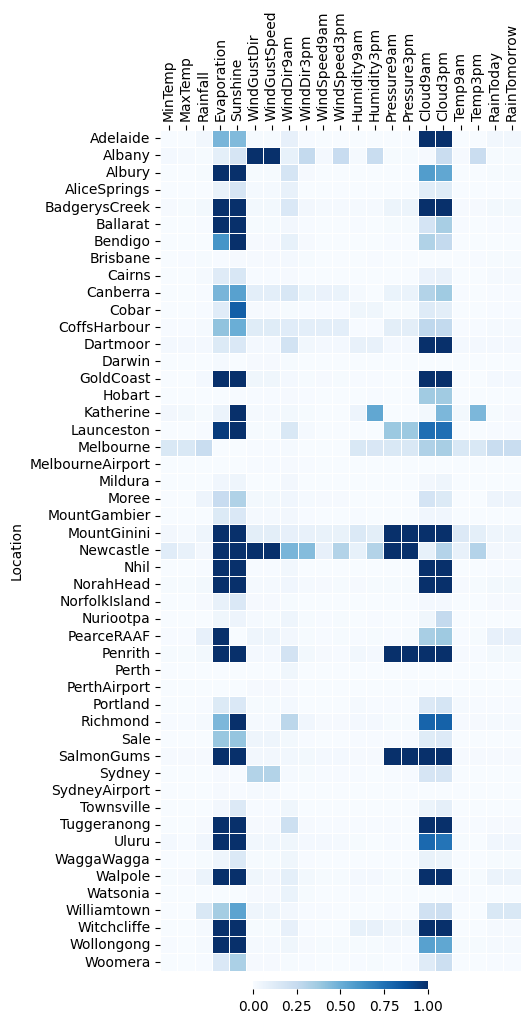

In [8]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    tmp = (data
           .groupby('Location')
           .apply(lambda x:
                  x.drop(['Location', 'Date'], axis=1)
                  .isna()
                  .mean()))

plt.figure(figsize=(9, 13))

ax = sns.heatmap(tmp,
                 cmap='Blues',
                 linewidth=0.5,
                 square=True,
                 cbar_kws=dict(
                     location="bottom",
                     pad=0.01,
                     shrink=0.25))

ax.xaxis.tick_top()
ax.tick_params(axis='x', labelrotation=90)

In [9]:
data = data[data.columns[data.isna().mean().lt(0.35)]]

data = data.dropna(subset='RainTomorrow')

### Огляд даних за типами

In [10]:
data_num = data.select_dtypes(include=np.number)
data_cat = data.select_dtypes(include='object')

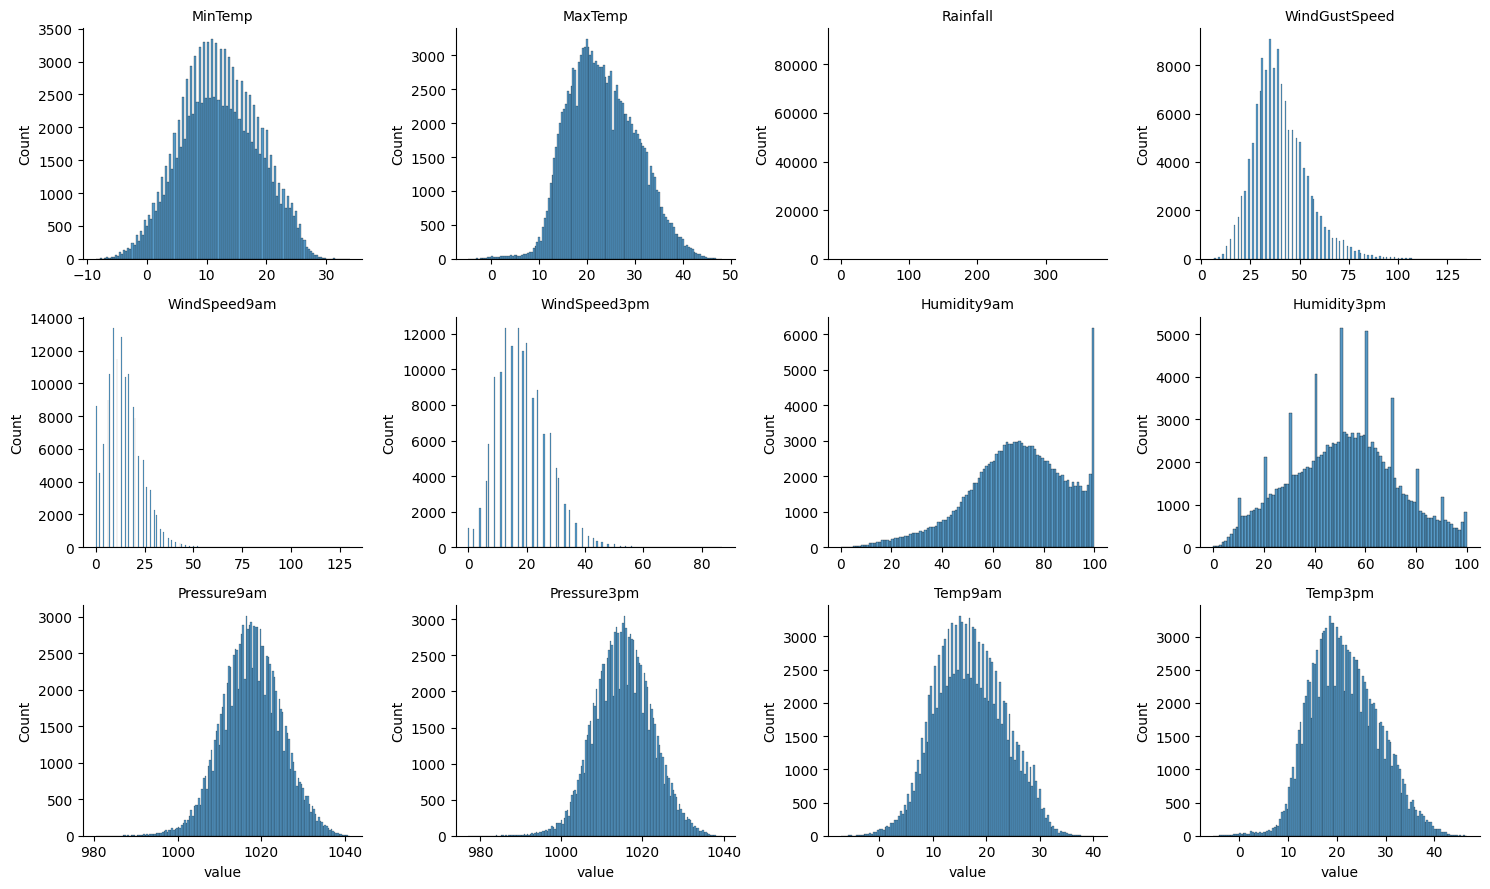

In [11]:
melted = data_num.melt()

g = sns.FacetGrid(melted,
                  col='variable',
                  col_wrap=4,
                  sharex=False,
                  sharey=False,
                  aspect=1.25)

g.map(sns.histplot, 'value')

g.set_titles(col_template='{col_name}')

g.tight_layout()

In [12]:
data_cat.nunique()

Date            3436
Location          49
WindGustDir       16
WindDir9am        16
WindDir3pm        16
RainToday          2
RainTomorrow       2
dtype: int64

In [13]:
data_cat.apply(lambda x: x.unique()[:5])

Date            [2008-12-01, 2008-12-02, 2008-12-03, 2008-12-0...
Location        [Albury, BadgerysCreek, Cobar, CoffsHarbour, M...
WindGustDir                                [W, WNW, WSW, NE, NNW]
WindDir9am                                  [W, NNW, SE, ENE, SW]
WindDir3pm                                   [WNW, WSW, E, NW, W]
RainToday                                          [No, Yes, nan]
RainTomorrow                                            [No, Yes]
dtype: object

In [14]:
data_cat['Date'] = pd.to_datetime(data['Date'])

data_cat[['Year', 'Month']] = (data_cat['Date']
                               .apply(lambda x:
                                      pd.Series([x.year, x.month])))

data_cat.drop('Date', axis=1, inplace=True)

data_cat[['Year', 'Month']] = data_cat[['Year', 'Month']].astype(str)

data_cat[['Year', 'Month']].head()

,Year,Month
0,2008,12
1,2008,12
2,2008,12
3,2008,12
4,2008,12


# Практика застосування логістичної регресії. Підготовка й обробка даних

### Розбиття на тренувальну й тестову вибірки

In [15]:
X_train_num, X_test_num, X_train_cat,  X_test_cat, y_train, y_test = (
    train_test_split(
        data_num,
        data_cat.drop('RainTomorrow', axis=1),
        data['RainTomorrow'],
        test_size=0.2,
        random_state=42))

### Відновлення пропущених значень

In [16]:
num_imputer = SimpleImputer().set_output(transform='pandas')
X_train_num = num_imputer.fit_transform(X_train_num)
X_test_num = num_imputer.transform(X_test_num)

pd.concat([X_train_num, X_test_num]).isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
dtype: int64

In [17]:
cat_imputer = SimpleImputer(
    strategy='most_frequent').set_output(transform='pandas')
X_train_cat = cat_imputer.fit_transform(X_train_cat)
X_test_cat = cat_imputer.transform(X_test_cat)

pd.concat([X_train_cat, X_test_cat]).isna().sum()

Location       0
WindGustDir    0
WindDir9am     0
WindDir3pm     0
RainToday      0
Year           0
Month          0
dtype: int64

### Нормалізація змінних

In [18]:
scaler = StandardScaler().set_output(transform='pandas')

X_train_num = scaler.fit_transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

### Onehot кодування категоріальних змінних

In [19]:
encoder = (OneHotEncoder(drop='if_binary',
                         sparse_output=False)
           .set_output(transform='pandas'))

X_train_cat = encoder.fit_transform(X_train_cat)
X_test_cat = encoder.transform(X_test_cat)

X_train_cat.shape

(113754, 121)

In [20]:
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

X_train.shape

(113754, 133)

# Практика застосування логістичної регресії. Навчання й оцінка моделі

### Розподіл цільової змінної

In [21]:
y_train.value_counts(normalize=True)

RainTomorrow
No     0.775516
Yes    0.224484
Name: proportion, dtype: float64

In [22]:
clf = (LogisticRegression(solver='liblinear',
                          class_weight='balanced',
                          random_state=42)
       .fit(X_train, y_train))

pred = clf.predict(X_test)

### Оцінювання точності моделі

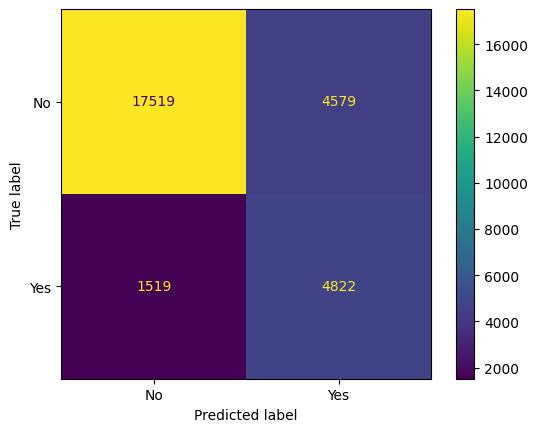

In [23]:
ConfusionMatrixDisplay.from_predictions(y_test, pred)

In [24]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          No       0.92      0.79      0.85     22098
         Yes       0.51      0.76      0.61      6341

    accuracy                           0.79     28439
   macro avg       0.72      0.78      0.73     28439
weighted avg       0.83      0.79      0.80     28439

